In [ ]:

import numpy as np
import torch
import torch.nn as nn
import random
import os
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.io
import torch.nn.functional as F
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate

# 转换时间格式，将字符串转换成时间戳
def convert_to_timestamp(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    dt = datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)
    return dt.timestamp()


# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split('/')[-1].split('.')[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0]
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), convert_to_timestamp(col[i][2][0]), d2
        data.append(d1)

    return data


# F1：充电电压从 3.8V 到 4.2V 的时间间隔（恒流阶段）
def getF1(Battery):
    cycle, timediff = [], []
    tolerance=0.1
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'charge':
            voltages = Bat['data']['Voltage_measured']
            times = Bat['data']['Time']
            for k in range(len(voltages)):
                if abs(voltages[k] - 3.8) <= tolerance:
                    for j in range(k + 1, len(voltages)):
                        if abs(voltages[j] - 4.2) <= tolerance and j-k>50:
                            timediff.append(times[j] - times[k])
                            cycle.append(i)
                            break
                    break
            i += 1

    return [cycle, timediff]

# F2：充电电流从 1.5A 到 0.5A 的时间间隔（恒压阶段）
def getF2(Battery):
    cycle, timediff = [], []
    tolerance=0.05
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'charge':
            currents = Bat['data']['Current_measured']
            times = Bat['data']['Time']
            for k in range(len(currents)):
                if abs(currents[k] - 1.5) <= tolerance:
                    for j in range(k + 1, len(currents)):
                        if abs(currents[j] - 0.5) <= tolerance and j-k>50:
                            timediff.append(times[j] - times[k])
                            cycle.append(i)
                            break
                    break
            i += 1

    return [cycle, timediff]

# F3：放电电压从 4.0V 到 3.2V 的时间间隔（放电过程）
def getF3(Battery):
    cycle, timediff = [], []
    tolerance=0.1
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            voltages = Bat['data']['Voltage_measured']
            times = Bat['data']['Time']
            for k in range(len(voltages)):
                if abs(voltages[k] - 4.0) <= tolerance:
                    for j in range(k + 1, len(voltages)):
                        if abs(voltages[j] - 3.2) <= tolerance and j-k>50:
                            timediff.append(times[j] - times[k])
                            cycle.append(i)
                            break
                    break
            i += 1

    return [cycle, timediff]

# F4：充电过程中温度达到峰值的时间
def getF4(Battery):
    cycle, timediff = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'charge':
            
            temps = Bat['data']['Temperature_measured']
            times = Bat['data']['Time']
            highest_temp = temps[0]
            highest_index = 0
            for k in range(len(temps)):
                if temps[k] > highest_temp:
                    highest_temp = temps[k]
                    highest_index = k

            timediff.append(times[highest_index]-times[0])
            cycle.append(i)
            i += 1

    return [cycle, timediff]


# F5：放电过程中温度达到峰值的时间
def getF5(Battery):
    cycle, timediff = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            
            temps = Bat['data']['Temperature_measured']
            times = Bat['data']['Time']
            highest_temp = temps[0]
            highest_index = 0
            for k in range(len(temps)):
                if temps[k] > highest_temp:
                    highest_temp = temps[k]
                    highest_index = k

            timediff.append(times[highest_index]-times[0])
            cycle.append(i)
            i += 1

    return [cycle, timediff]


# F6：恒流阶段，相等电压差的能量
def getF6(Battery):
    cycle, diff = [], []
    tolerance=0.1
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'charge':
            voltages = Bat['data']['Voltage_measured']
            currents = Bat['data']['Current_measured']
            times = Bat['data']['Time']
            volts=[]
            curts=[]
            tims=[]
            start=0
            end=0
            for k in range(len(voltages)):
                if abs(voltages[k] - 3.8) <= tolerance:
                    for j in range(k + 1, len(voltages)):
                        if abs(voltages[j] - 4.2) <= tolerance and j-k>50:
                            start=k
                            end=j
                            break
                    break
            for l in range(start,end+1):
                volts.append(voltages[l])
                curts.append(currents[l])
                tims.append(times[l])

            volts = np.array(volts)
            curts = np.array(curts)
            tims = np.array(tims)

   
            diff.append(np.trapezoid(volts * curts, tims))
            cycle.append(i)
            i += 1

    return [cycle, diff]

# F7：恒压阶段，相等电流差的能量
def getF7(Battery):
    cycle, diff = [], []
    tolerance=0.05
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'charge':
            voltages = Bat['data']['Voltage_measured']
            currents = Bat['data']['Current_measured']
            times = Bat['data']['Time']
            volts=[]
            curts=[]
            tims=[]
            start=0
            end=0
            for k in range(len(currents)):
                if abs(currents[k] - 1.5) <= tolerance:
                    for j in range(k + 1, len(currents)):
                        if abs(currents[j] - 0.5) <= tolerance and j-k>50:
                            start=k
                            end=j
                            break
                    break
            for l in range(start,end+1):
                volts.append(voltages[l])
                curts.append(currents[l])
                tims.append(times[l])

            volts = np.array(volts)
            curts = np.array(curts)
            tims = np.array(tims)

   
            diff.append(np.trapezoid(volts * curts, tims))
            cycle.append(i)
            i += 1

    return [cycle, diff]

# F8：放电过程，相等电压差的能量
def getF8(Battery):
    cycle, diff = [], []
    tolerance=0.1
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            voltages = Bat['data']['Voltage_measured']
            currents = Bat['data']['Current_measured']
            times = Bat['data']['Time']
            volts=[]
            curts=[]
            tims=[]
            start=0
            end=0
            for k in range(len(voltages)):
                if abs(voltages[k] - 4.0) <= tolerance:
                    for j in range(k + 1, len(voltages)):
                        if abs(voltages[j] - 3.2) <= tolerance and j-k>50:
                            start=k
                            end=j
                            break
                    break
            for l in range(start,end+1):
                volts.append(voltages[l])
                curts.append(currents[l])
                tims.append(times[l])

            volts = np.array(volts)
            curts = np.array(curts)
            tims = np.array(tims)

   
            diff.append(np.trapezoid(volts * curts, tims))
            cycle.append(i)
            i += 1

    return [cycle, diff]

# F9：增量容量曲线的峰值
def getF9(Battery):
    cycle, diff = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            voltage = Bat['data']['Voltage_measured']
            current = Bat['data']['Current_measured']
            time = Bat['data']['Time']
            # 计算增量容量
            dV = np.diff(voltage)
            dT = np.diff(time)
            dT_dV = dT / dV
            # 计算增量容量 dQ/dV
            dQ_dV = current[:-1] * dT_dV
            F9 = np.max(dQ_dV)
            diff.append(F9)
            cycle.append(i)
            i += 1

    return [cycle, diff]

# F10：增量容量曲线峰值对应的电压
def getF10(Battery):
    cycle, diff = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            voltage = Bat['data']['Voltage_measured']
            current = Bat['data']['Current_measured']
            time = Bat['data']['Time']
            # 计算增量容量
            dV = np.diff(voltage)
            dT = np.diff(time)
            dT_dV = dT / dV
            # 计算增量容量 dQ/dV
            dQ_dV = current[:-1] * dT_dV
            F10 = voltage[np.argmax(dQ_dV)]
            diff.append(F10)
            cycle.append(i)
            i += 1

    return [cycle, diff]

def getSOH(Battery):
    cycle, soh=[], []
    rated=2.0
    i=1
    for Bat in Battery: 
        if Bat['type'] == 'discharge':
            capacity = Bat['data']['Capacity'][0]
            cycle.append(i)
            soh.append(capacity/rated)
            i=i+1
    return [cycle, soh]






Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = '/Users/jerry/Desktop/未命名文件夹/'



def preprocess_features(Battery, Battery_list):
    """Preprocess and align all features to the same length using interpolation."""
    processed_features = {}
    
    for name in Battery_list:
        
        f1 = getF1(Battery[name])
        f2 = getF2(Battery[name])
        f3 = getF3(Battery[name])
        f4 = getF4(Battery[name])
        f5 = getF5(Battery[name])
        f6 = getF6(Battery[name])
        f7 = getF7(Battery[name])
        f8 = getF8(Battery[name])
        f9 = getF9(Battery[name])
        f10 = getF10(Battery[name])
        soh = getSOH(Battery[name])
        
        # Get the length of SOH data as reference length
        target_length = len(soh[1])
        
        # Initialize scalers for each feature
        scalers = [MinMaxScaler() for _ in range(10)]
        
        # Process each feature
        features = []
        for idx, (cycles, values) in enumerate([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]):
            # Create interpolation function
            f = interpolate.interp1d(cycles, values, kind='linear', fill_value='extrapolate')
            
            # Generate new x points matching SOH length
            new_x = np.linspace(1, target_length, target_length)
            
            # Interpolate values
            interpolated_values = f(new_x)
            
            # Scale the features
            scaled_values = scalers[idx].fit_transform(interpolated_values.reshape(-1, 1)).flatten()
            
            features.append(scaled_values)
            
        processed_features[name] = {
            'features': np.array(features).T,  # Shape: (n_samples, n_features)
            'soh': np.array(soh[1])
        }
    
    return processed_features

class MultiFeatureNet(nn.Module):
    def __init__(self, input_size=10, hidden_dim=128, num_layers=1):
        super(MultiFeatureNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, 
                           num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
 
    def forward(self, x):           # x shape: (batch_size, sequence_length, n_features)
        out, _ = self.cell(x)       
        out = out[:, -1, :]         # Take the last time step output
        out = self.linear(out)      
        return out

def build_multi_feature_instances(features, soh, window_size):
    x, y = [], []
    for i in range(len(soh) - window_size):
        feature_sequence = features[i:i+window_size]
        target = soh[i+window_size]
        
        x.append(feature_sequence)
        y.append(target)
    
    return np.array(x), np.array(y)

def get_train_test_multi_feature(processed_features, name, window_size=8):
    """Prepare training and testing data for multi-feature input."""
    current_data = processed_features[name]
    features, soh = current_data['features'], current_data['soh']
    
    # Split into initial training and testing
    train_features = features[:window_size+1]
    train_soh = soh[:window_size+1]
    test_features = features[window_size+1:]
    test_soh = soh[window_size+1:]
    
    train_x, train_y = build_multi_feature_instances(train_features, train_soh, window_size)
    
    for k, v in processed_features.items():
        if k != name:
            other_x, other_y = build_multi_feature_instances(v['features'], v['soh'], window_size)
            train_x = np.concatenate([train_x, other_x])
            train_y = np.concatenate([train_y, other_y])
    
    return train_x, train_y, list(train_soh), list(test_soh)

def train_multi_feature(processed_features, lr=0.001, feature_size=16, hidden_dim=128, 
                       num_layers=1, weight_decay=0.0, epochs=500, seed=0, 
                       device='cpu', metric='rmse'):
    score_list, result_list = [], []
    setup_seed(seed)
    
    for name in Battery_list:
        train_x, train_y, train_data, test_data = get_train_test_multi_feature(
            processed_features, name, feature_size)
        
        test_sequence = train_data + test_data
        test_features = processed_features[name]['features']
        test_x, test_y = build_multi_feature_instances(test_features, test_sequence, feature_size)
        
        model = MultiFeatureNet(input_size=10, hidden_dim=hidden_dim, num_layers=num_layers)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()
        
        loss_list, y_ = [0], []
        score_, score = 1, 1
        rmse, re = 1, 1  # Initialize these variables outside the epoch loop
        
        for epoch in range(epochs):
            X = torch.from_numpy(train_x).float().to(device)
            y = torch.from_numpy(train_y).float().to(device).reshape(-1, 1)
            
            output = model(X)
            loss = criterion(output, y)
            optimizer.zero_grad()            
            loss.backward()                    
            optimizer.step()                   

            if (epoch + 1) % 100 == 0:
                x = torch.from_numpy(test_x).float().to(device)
                pred = model(x)
                point_list = pred.data.cpu().numpy().reshape(-1)
                
                y_.append(point_list)
                loss_list.append(loss.item())
                rmse = evaluation(y_test=test_y, y_predict=y_[-1])
                re = relative_error(y_test=test_y, y_predict=y_[-1], 
                                  threshold=Rated_Capacity*0.7)
            
            score = [re] if metric == 're' else [rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(train_data[:-1] + list(y_[-1]))
    
    return score_list, result_list

def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
            
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
            
    score = abs(true_re - pred_re)/true_re
    if score > 1: score = 1
        
    return score

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = data 
processed_features = preprocess_features(Battery, Battery_list)
score_list, prediction_list = train_multi_feature(
    processed_features,
    lr=0.001,
    feature_size=16,
    hidden_dim=128,
    num_layers=1,
    epochs=500,
    seed=0
)

Load Dataset B0005.mat ...


/var/folders/6w/9gtqd_9j3rz41r1rzgxcd9h00000gn/T/ipykernel_8896/3254620500.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), convert_to_timestamp(col[i][2][0]), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


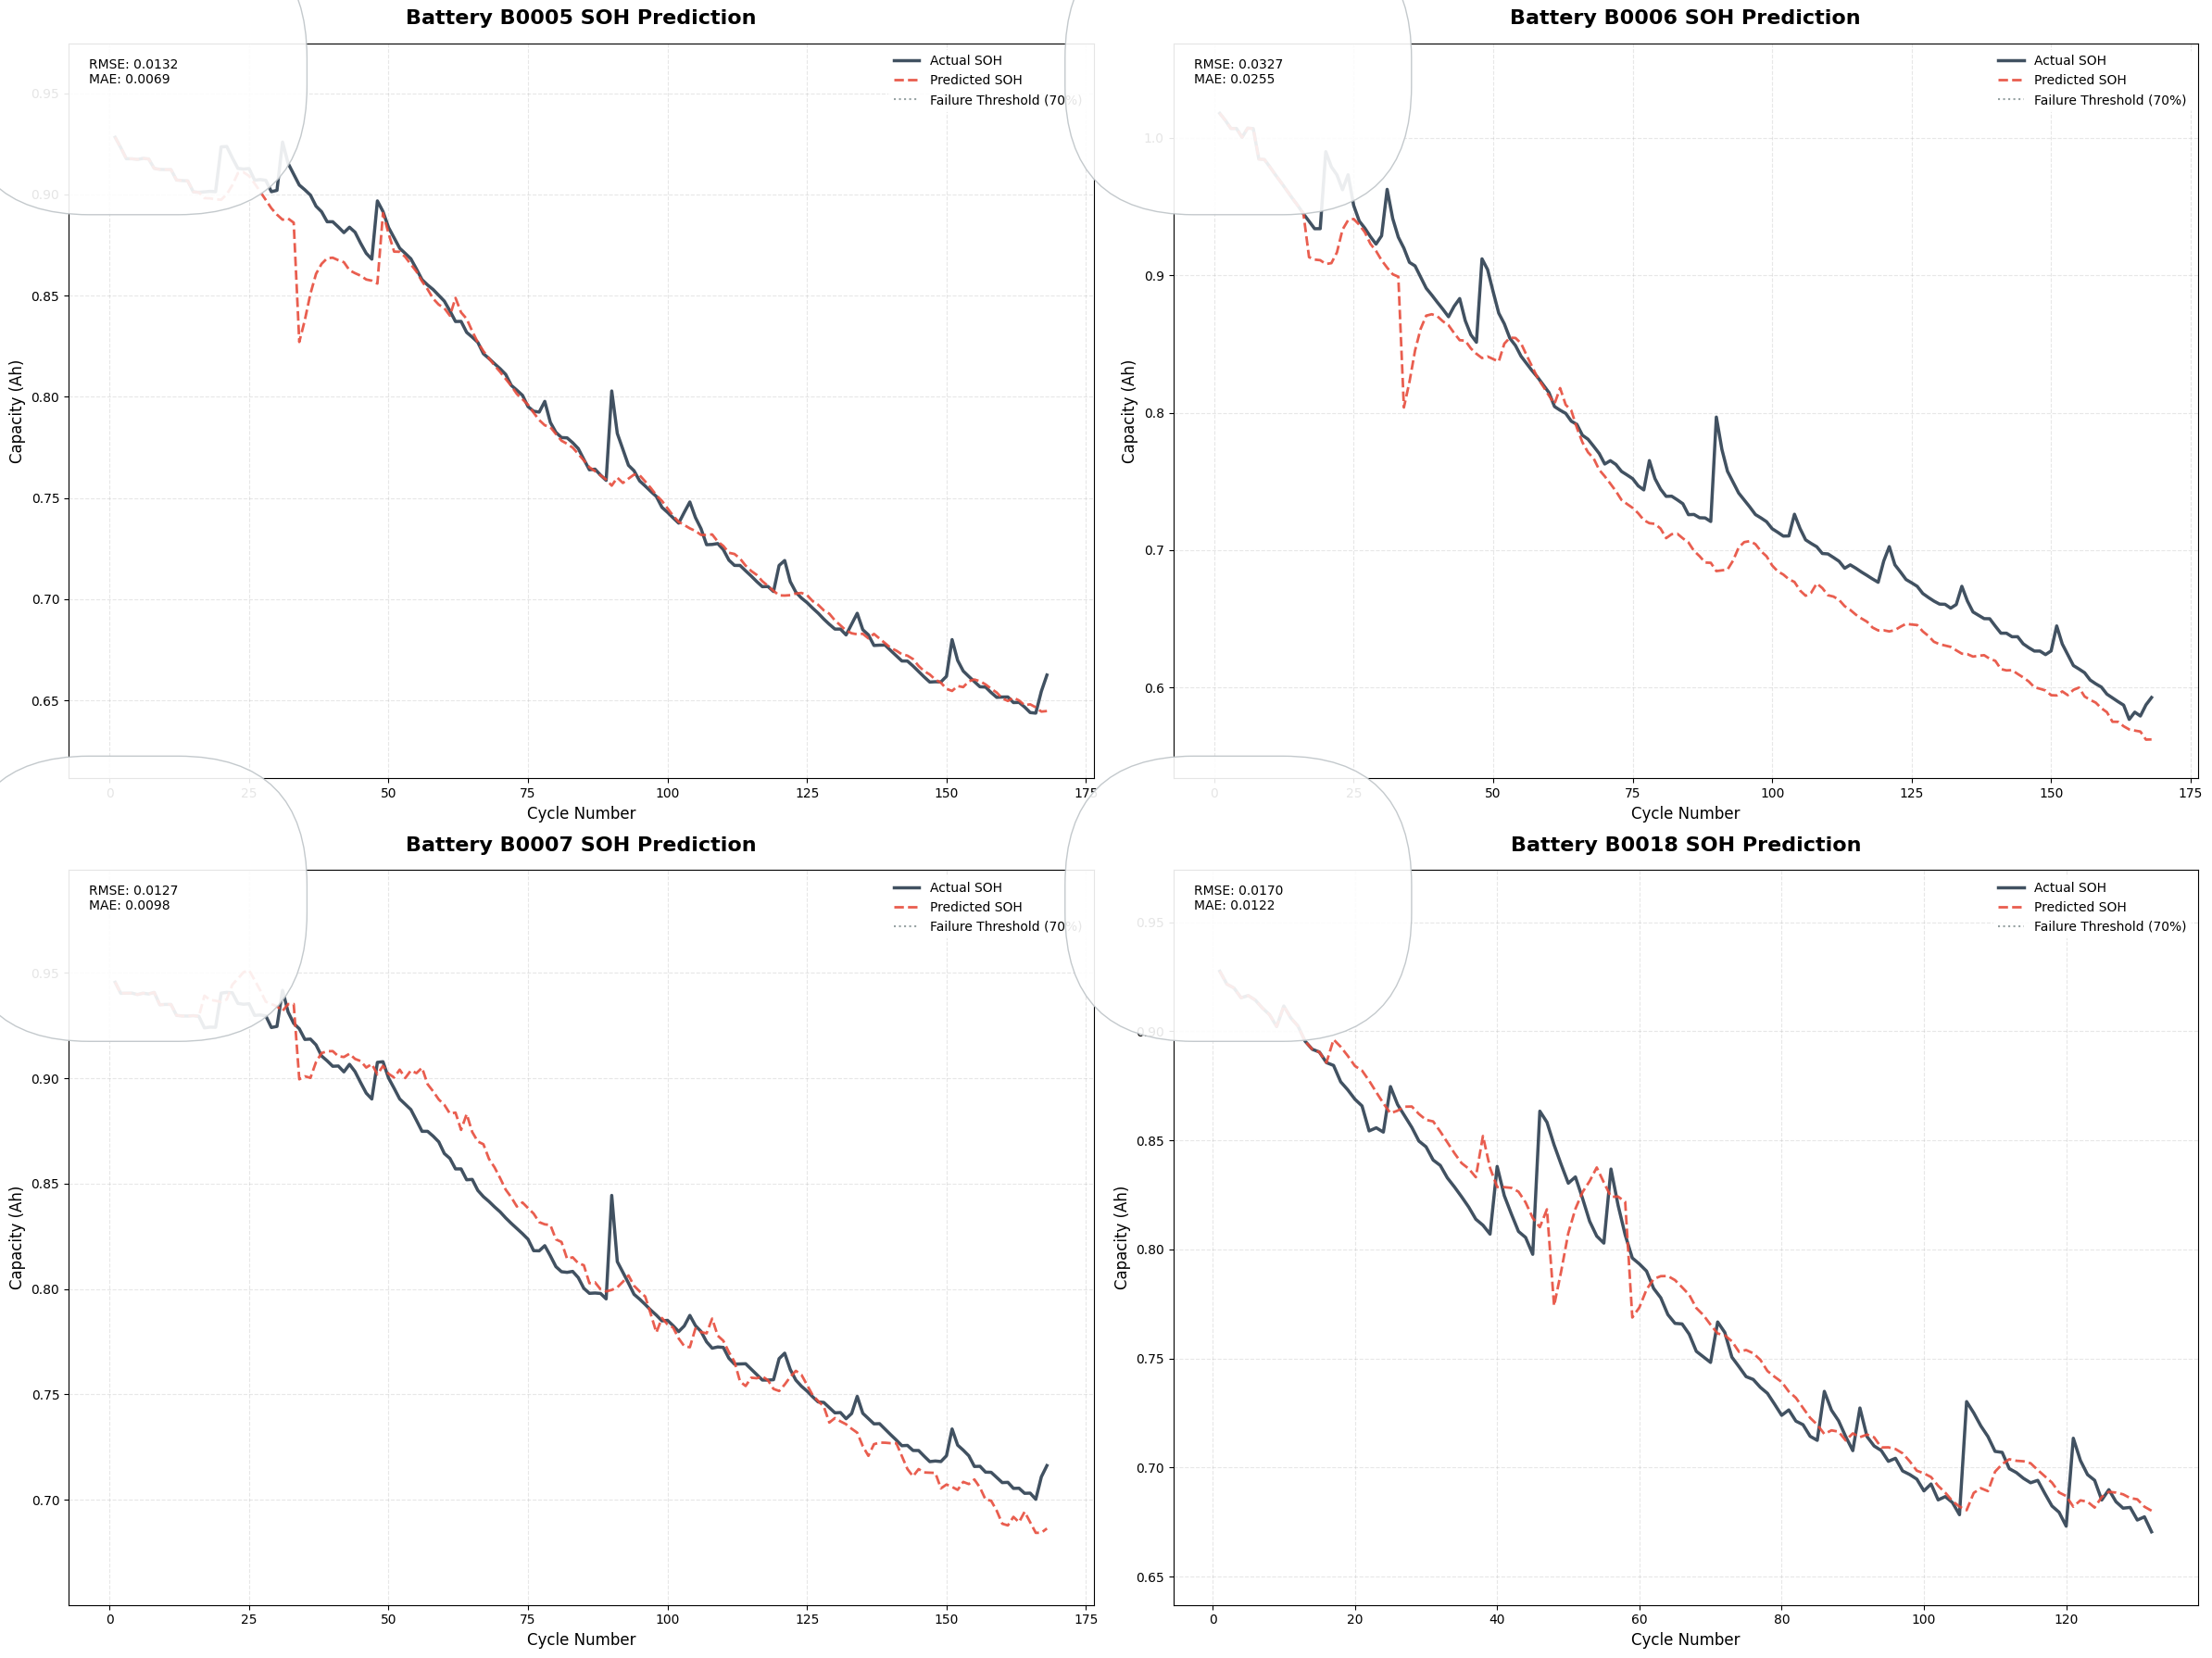

In [27]:
def visualize_predictions(Battery_list, prediction_list, processed_features, Rated_Capacity=2.0):
    """
    Create a comprehensive visualization of battery SOH predictions vs actual values.
    
    Args:
        Battery_list: List of battery names to visualize
        prediction_list: List of predictions for each battery
        processed_features: Dictionary containing processed battery data
        Rated_Capacity: The rated capacity of the batteries (default: 2.0 Ah)
    """
    
    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(24, 18))
    
    # Set global style parameters
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['axes.grid'] = True
    
    for i in range(2):
        for j in range(2):
            idx = i * 2 + j
            battery_name = Battery_list[idx]
            
            # Get actual SOH values
            actual_soh = processed_features[battery_name]['soh']
            predicted_soh = prediction_list[idx]
            
            # Create cycle numbers for x-axis
            cycles = np.arange(1, len(actual_soh) + 1)
            
            # Plot data
            ax = axes[i][j]
            
            # Plot with custom colors and styles
            ax.plot(cycles, actual_soh, 
                   color='#2C3E50',  # Dark blue for actual values
                   linewidth=2.5, 
                   label='Actual SOH',
                   alpha=0.9)
            
            ax.plot(cycles, predicted_soh, 
                   color='#E74C3C',  # Red for predictions
                   linewidth=2, 
                   linestyle='--', 
                   label='Predicted SOH',
                   alpha=0.9)
            
            # Add threshold line
            threshold = np.ones_like(cycles) * (Rated_Capacity * 0.7)
            ax.plot(cycles, threshold, 
                   color='#7F8C8D',  # Gray for threshold
                   linestyle=':', 
                   linewidth=1.5, 
                   label='Failure Threshold (70%)',
                   alpha=0.8)
            
            # Customize plot appearance
            ax.set_title(f'Battery {battery_name} SOH Prediction', 
                        fontsize=16, 
                        pad=15, 
                        fontweight='bold')
            
            ax.set_xlabel('Cycle Number', fontsize=12)
            ax.set_ylabel('Capacity (Ah)', fontsize=12)
            
            # Customize grid
            ax.grid(True, linestyle='--', alpha=0.3)
            
            # Customize legend
            ax.legend(fontsize=10, 
                     loc='upper right', 
                     framealpha=0.95,
                     edgecolor='none')
            
            # Add error metrics
            rmse = np.sqrt(mean_squared_error(actual_soh, predicted_soh))
            mae = mean_absolute_error(actual_soh, predicted_soh)
            
            # Add metrics box with custom styling
            metrics_text = f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}'
            ax.text(0.02, 0.98, metrics_text,
                   transform=ax.transAxes,
                   fontsize=10,
                   verticalalignment='top',
                   bbox=dict(facecolor='white',
                           edgecolor='#BDC3C7',
                           alpha=0.9,
                           pad=10,
                           boxstyle='round'))
            
            # Set axis limits with some padding
            ax.set_ylim(min(min(actual_soh), min(predicted_soh)) * 0.95,
                       max(max(actual_soh), max(predicted_soh)) * 1.05)
            
    plt.tight_layout()
    return fig

# Use the visualization function
fig = visualize_predictions(Battery_list, prediction_list, processed_features)
plt.show()